<a href="https://colab.research.google.com/github/GurgenGulay/Titanic/blob/main/Titanik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

# Görsel ayarlamalar
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


In [ ]:
file_path = '/content/titanic.csv'
df = pd.read_csv(file_path)

print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/titanic.csv'

In [ ]:
df.shape

# Data Preprocessing

## 1. Feature Engineering (Değişken Mühendisliği)

In [ ]:
df.columns = [col.upper() for col in df.columns]
df.head()

In [ ]:
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int64')

df["NEW_NAME_COUNT"] = df["NAME"].str.len()

df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))

df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

df["NEW_TITLE"] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)

df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1

df.loc[((df["SIBSP"] + df["PARCH"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SIBSP"] + df["PARCH"]) == 0), "NEW_IS_ALONE"] = "YES"

df.loc[(df["AGE"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), "NEW_AGE_CAT"] = "mature"
df.loc[(df["AGE"] >= 56), "NEW_AGE_CAT"] = "senior"

df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 21) & (df["AGE"] <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 21) & (df["AGE"] <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"


df.head()



*       
  Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
*   Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.




In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations(Gözlem): {dataframe.shape[0]}")
    print(f"Variables(Değişken): {dataframe.shape[1]}")
    print(f'cat_cols(kategorik Değişken): {len(cat_cols)}')
    print(f'num_cols(Numerik değişken): {len(num_cols)}')
    print(f'cat_but_car(Kardinal değişken): {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [ ]:
cat_cols

In [ ]:
num_cols

In [ ]:
cat_but_car

In [ ]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]
num_cols

## 2. Outliers (Aykırı Değerler)

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in num_cols:
    print(col, check_outlier(df, col))

In [ ]:
def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [ ]:
for col in num_cols:
    print(col, check_outlier(df, col))

## 3. Missing Values (Eksik Değerler)

In [ ]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [ ]:
missing_values_table(df)

In [ ]:
df.drop("CABIN", inplace=True, axis=1)

missing_values_table(df)

In [ ]:
remove_cols = ["TICKET", "NAME"]

missing_values_table(df)

In [ ]:
df.drop(remove_cols, inplace=True, axis=1)

df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))
missing_values_table(df)

In [ ]:
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [ ]:
missing_values_table(df)

In [ ]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

missing_values_table(df)

## 4. Label Encoding

In [ ]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [ ]:
binary_cols = [col for col in df.columns if df[col].dtype not in ["int64", "float64"]
               and df[col].nunique() == 2]
binary_cols

['SEX', 'NEW_IS_ALONE']

In [ ]:
for col in binary_cols:
    df = label_encoder(df, col)

## 5. Rare Encoding

In [ ]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")



rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


EMBARKED : 3
   COUNT  RATIO  TARGET_MEAN
C    168  0.189        0.554
Q     77  0.086        0.390
S    646  0.725        0.339


NEW_TITLE : 17
          COUNT  RATIO  TARGET_MEAN
Capt          1  0.001        0.000
Col           2  0.002        0.500
Countess      1  0.001        1.000
Don           1  0.001        0.000
Dr            7  0.008        0.429
Jonkheer      1  0.001        0.000
Lady          1  0.001        1.000
Major         2  0.002        0.500
Master       40  0.045        0.575
Miss        182  0.204        0.698
Mlle          2  0.002        1.000
Mme           1  0.001        1.000
Mr          517  0.580        0.157
Mrs         125  0.140        0.792
Ms            1  0.001        1.000
Rev           6  0.007        0.000
Sir           1  0.001        1.000


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304


N

In [ ]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'RARE', temp_df[var])

    return temp_df


df = rare_encoder(df, 0.01)

df["NEW_TITLE"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
RARE       27
Name: NEW_TITLE, dtype: int64

## 6. One-Hot Encoding

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [ ]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['PCLASS',
 'SIBSP',
 'PARCH',
 'EMBARKED',
 'NEW_NAME_WORD_COUNT',
 'NEW_TITLE',
 'NEW_FAMILY_SIZE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT']

In [ ]:
def oneHotEncoder(dataframe, categoricalCols, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns=categoricalCols,drop_first=drop_first)
    return dataframe
df = oneHotEncoder(df, ohe_cols)
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_RARE,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_mature,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.000,7.250,0,23,0,66.000,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2,1,0,38.000,65.634,1,45,0,38.000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,3,1,0,26.000,7.925,0,22,0,78.000,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,4,1,0,35.000,53.100,1,44,0,35.000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,5,0,1,35.000,8.050,0,24,0,105.000,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations(Gözlem): 891
Variables(Değişken): 61
cat_cols(kategorik Değişken): 56
num_cols(Numerik değişken): 5
cat_but_car(Kardinal değişken): 0
num_but_cat: 56


In [ ]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [ ]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
   COUNT  RATIO  TARGET_MEAN
0    549  0.616        0.000
1    342  0.384        1.000


SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


NEW_CABIN_BOOL : 2
   COUNT  RATIO  TARGET_MEAN
0    687  0.771        0.300
1    204  0.229        0.667


NEW_NAME_DR : 2
   COUNT  RATIO  TARGET_MEAN
0    881  0.989        0.383
1     10  0.011        0.500


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304


PCLASS_1 : 2
   COUNT  RATIO  TARGET_MEAN
0    675  0.758        0.305
1    216  0.242        0.630


PCLASS_2 : 2
   COUNT  RATIO  TARGET_MEAN
0    707  0.793        0.361
1    184  0.207        0.473


PCLASS_3 : 2
   COUNT  RATIO  TARGET_MEAN
0    400  0.449        0.557
1    491  0.551        0.242


SIBSP_0 : 2
   COUNT  RATIO  TARGET_MEAN
0    283  0.318        0.466
1    608  0.682        0.345


SIBSP_1 : 2
   COUNT  RATIO  TARGET_MEAN
0    682  0.765        0.337
1    

In [ ]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
useless_cols

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

## 7. Standart Scaler

In [ ]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.561,-0.821,-0.437,0.066
1,0.663,2.032,2.248,-0.790
2,-0.255,-0.788,-0.559,0.434
3,0.434,1.419,2.126,-0.882
4,0.434,-0.781,-0.315,1.260


In [ ]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_RARE,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_mature,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,-0.561,-0.821,0,-0.437,0,0.066,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2,1,0,0.663,2.032,1,2.248,0,-0.790,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,3,1,0,-0.255,-0.788,0,-0.559,0,0.434,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,4,1,0,0.434,1.419,1,2.126,0,-0.882,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,5,0,1,0.434,-0.781,0,-0.315,0,1.260,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


# MODEL


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [ ]:
y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

## kNN


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier().fit(X, y)

In [ ]:
random_user = X.sample(1, random_state=45)

knn_model.predict(random_user)

array([0])



*   Hyperparameter Optimization


In [ ]:
knn_model = KNeighborsClassifier()
knn_model.get_params()

knn_params = {"n_neighbors": range(2, 50)}
knn_gs_best = GridSearchCV(knn_model,
                           knn_params,
                           cv=5,
                           n_jobs=-1,
                           verbose=1).fit(X, y)

knn_gs_best.best_params_
# {'n_neighbors': 36}

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'n_neighbors': 11}

In [ ]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X, y)
cv_results = cross_validate(knn_final,
                            X,
                            y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.8170861841692298

In [ ]:
y_pred = knn_final.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       549
           1       0.85      0.73      0.78       342

    accuracy                           0.85       891
   macro avg       0.85      0.82      0.83       891
weighted avg       0.85      0.85      0.84       891



In [ ]:
y_probs = knn_model.predict_proba(X)
roc_auc_scores = roc_auc_score(pd.get_dummies(y), y_probs, multi_class="ovr")

print("Macro Average ROC AUC Score:", roc_auc_scores)

Macro Average ROC AUC Score: 0.9123472768137709


In [ ]:
conf_matrix = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

true_positive = conf_matrix[1, 1]
false_positive = conf_matrix[0, 1]
true_negative = conf_matrix[0, 0]
false_negative = conf_matrix[1, 0]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Confusion Matrix:
[[504  45]
 [ 93 249]]
Sensitivity: 0.7280701754385965
Specificity: 0.9180327868852459


In [ ]:
kappa = cohen_kappa_score(y, y_pred)
print(f"Cohen's Kappa: {kappa}")

Cohen's Kappa: 0.6636632200886263


## SVM


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn import datasets, svm
from sklearn.svm import SVC

In [ ]:
svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
svm.fit(X_train, y_train)


SVC(gamma=0.1, random_state=0)

In [ ]:

print("train accuracy:",svm.score(X_train,y_train))
print("test accuracy:",svm.score(X_test,y_test))

train accuracy: 0.8780096308186196
test accuracy: 0.7947761194029851


In [ ]:
y_pred = svm.predict(X_test)
print(y_pred)

[0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0
 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0
 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0]


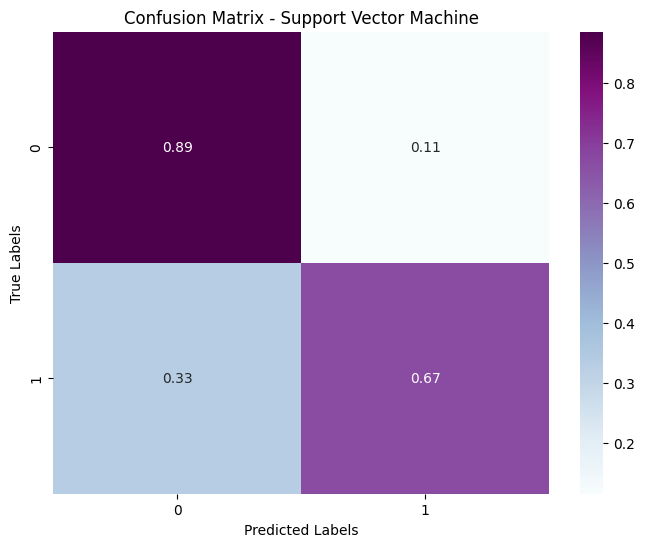

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred, normalize='true')

labels = sorted(y_test.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Support Vector Machine')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

report=classification_report(y_test, svm.predict(X_test))
print("Classification Report:")

lines = report.split('\n')
for line in lines:
    print(line)

Accuracy: 79.48%
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       157
           1       0.80      0.67      0.73       111

    accuracy                           0.79       268
   macro avg       0.80      0.78      0.78       268
weighted avg       0.80      0.79      0.79       268



In [ ]:
from sklearn.preprocessing import label_binarize

y_scores = svm.decision_function(X_test)
y_test_bin = label_binarize(y_test, classes=svm.classes_)

auc_score = roc_auc_score(y_test_bin, y_scores, average='weighted', multi_class='ovr')
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.8416824467779882


Test ROC AUC: 0.8416824467779882


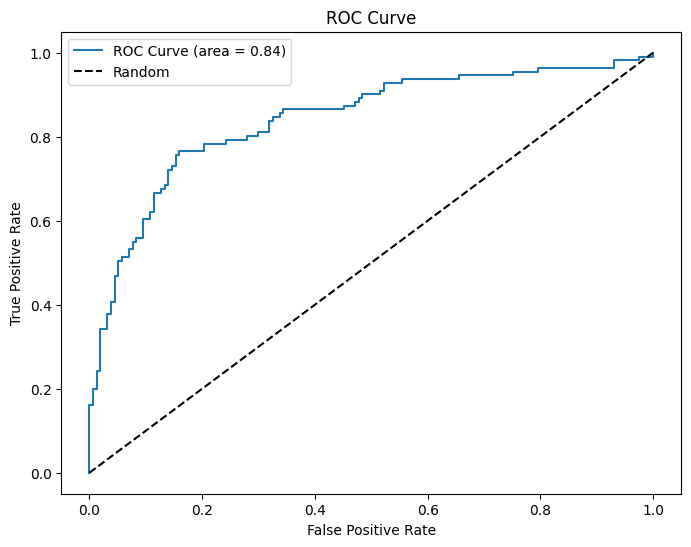

In [ ]:
roc_auc_test = roc_auc_score(y_test, y_scores)
fpr, tpr, _ = roc_curve(y_test, y_scores)
print("Test ROC AUC:", roc_auc_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.6666666666666666
Specificity: 0.8853503184713376


In [ ]:
observed_accuracy = accuracy_score(y_test, y_pred)
expected_accuracy = ((TN + FP) * (TN + FN) + (FP + TP) * (FN + TP)) / (len(y_test) ** 2)
kappa = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)
print("Kappa:", kappa)

Kappa: 0.5662154208357858


## Karar Ağaçları


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(random_state=122)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

In [ ]:
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tree.fit(X_train, y_train)

print('Best Parameters: ', grid_search_tree.best_params_)
print('Best Accuracy: ', grid_search_tree.best_score_)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
Best Accuracy:  0.8073548387096775


In [ ]:
best_tree = grid_search_tree.best_estimator_

test_accuracy = best_tree.score(X_test, y_test)
print('Test Accuracy: ', test_accuracy)

Test Accuracy:  0.7574626865671642


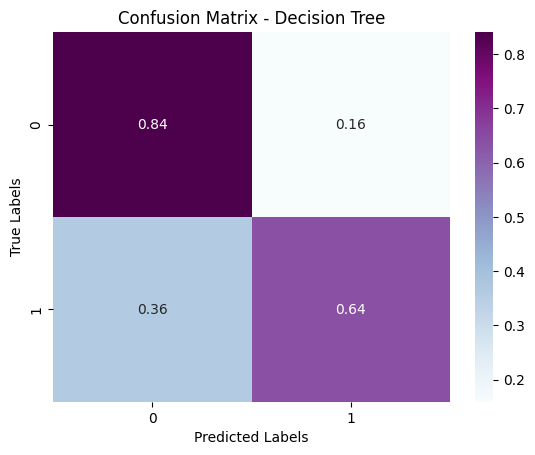

In [ ]:
y_pred = best_tree.predict(X_test)

labels = y_test.unique()

cm_tree = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure()
sns.heatmap(cm_tree, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       157
           1       0.74      0.64      0.69       111

    accuracy                           0.76       268
   macro avg       0.75      0.74      0.74       268
weighted avg       0.76      0.76      0.75       268



Test ROC AUC: 0.7662822057726517


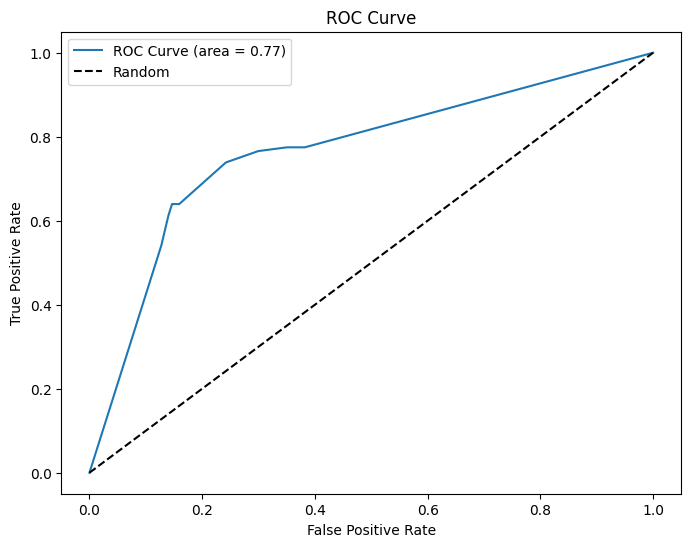

In [ ]:
y_test_pred_proba = best_tree.predict_proba(X_test)[:, 1]

roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
print("Test ROC AUC:", roc_auc_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("Specificity:", specificity)
print("Sensitivity:", sensitivity)


Specificity: 0.8407643312101911
Sensitivity: 0.6396396396396397


In [ ]:
observed_accuracy = (TP + TN) / (TP + TN + FP + FN)
expected_accuracy = ((TN + FP) * (TN + FN) + (FP + TP) * (FN + TP)) / ((TP + TN + FP + FN) ** 2)
kappa = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)
print("Kappa:", kappa)

Kappa: 0.4901065449010655


## Yapay Sinir Ağları


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [ ]:
num_classes = len(set(y_train))

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=num_classes, activation='sigmoid'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/15
20/20 [==============================] - 1s 16ms/step - loss: 0.5290 - accuracy: 0.7464 - val_loss: 0.4945 - val_accuracy: 0.7799
Epoch 2/15
20/20 [==============================] - 0s 4ms/step - loss: 0.4433 - accuracy: 0.8186 - val_loss: 0.4702 - val_accuracy: 0.8134
Epoch 3/15
20/20 [==============================] - 0s 4ms/step - loss: 0.4068 - accuracy: 0.8411 - val_loss: 0.4678 - val_accuracy: 0.7873
Epoch 4/15
20/20 [==============================] - 0s 4ms/step - loss: 0.3859 - accuracy: 0.8475 - val_loss: 0.4637 - val_accuracy: 0.8060
Epoch 5/15
20/20 [==============================] - 0s 4ms/step - loss: 0.3721 - accuracy: 0.8555 - val_loss: 0.4563 - val_accuracy: 0.8172
Epoch 6/15
20/20 [==============================] - 0s 4ms/step - loss: 0.3617 - accuracy: 0.8587 - val_loss: 0.4564 - val_accuracy: 0.8097
Epoch 7/15
20/20 [==============================] - 0s 4ms/step - loss: 0.3495 - accuracy: 0.8604 - val_loss: 0.4728 - val_accuracy: 0.8134
Epoch 8/15
20/20 [=

In [ ]:
y_train_pred_proba = model.predict(X_train)
y_train_pred = (y_train_pred_proba > 0.5).astype(int)

20/20 [==============================] - 0s 2ms/step


In [ ]:
y_test_pred_proba = model.predict(X_test)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

9/9 [==============================] - 0s 2ms/step


In [ ]:
# Train accuracy
y_train_pred_proba = model.predict(X_train)
y_train_pred = y_train_pred_proba.argmax(axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Test accuracy
y_test_pred_proba = model.predict(X_test)
y_test_pred = y_test_pred_proba.argmax(axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 0s 2ms/step
Train Accuracy: 0.8876404494382022
9/9 [==============================] - 0s 2ms/step
Test Accuracy: 0.7985074626865671


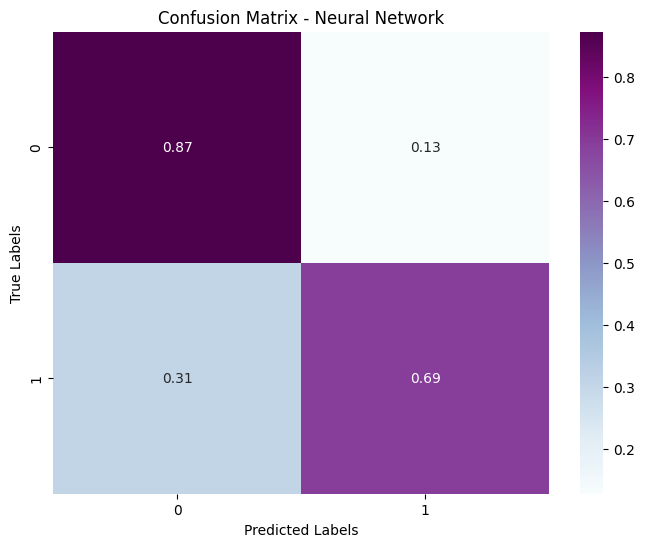

In [ ]:
cm_ann = confusion_matrix(y_test, y_test_pred, normalize='true')

labels = sorted(y_test.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ann, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[137  20]
 [ 34  77]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       157
           1       0.79      0.69      0.74       111

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.79       268
weighted avg       0.80      0.80      0.80       268



In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("Specificity:", specificity)
print("Sensitivity:", sensitivity)

Specificity: 0.8726114649681529
Sensitivity: 0.6936936936936937


In [ ]:
observed_accuracy = (TP + TN) / (TP + TN + FP + FN)
expected_accuracy = ((TN + FP) * (TN + FN) + (FP + TP) * (FN + TP)) / ((TP + TN + FP + FN) ** 2)
kappa = (observed_accuracy - expected_accuracy) / (1 - expected_accuracy)
print("Kappa:", kappa)

Kappa: 0.576965799473838


In [ ]:
y_train_pred_proba = model.predict(X_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)


print("Train ROC AUC:", roc_auc_train)

20/20 [==============================] - 0s 2ms/step
Train ROC AUC: 0.9317519215478398


In [ ]:
y_test_pred_proba = model.predict(X_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

print("Test ROC AUC:", roc_auc_test)

9/9 [==============================] - 0s 4ms/step
Test ROC AUC: 0.8272221265851839


Test ROC AUC: 0.8272221265851839


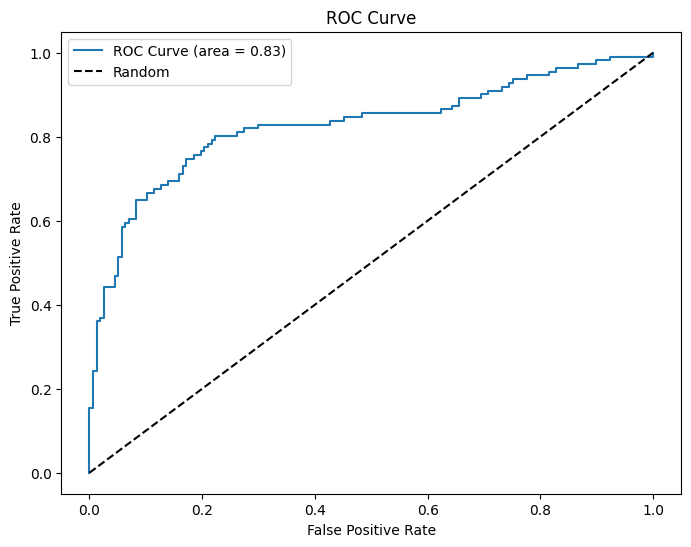

In [ ]:
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
print("Test ROC AUC:", roc_auc_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()